# Gender Classification

## Introduction
The aim of the article is to choose the best gender classification model between Logistic Regresson, Decision Tree Claifier, SVM and kNH algorithms. The particular thing about this is that we have relatively small data about famous public figures. We will also see how well the chosen model works for normal people like us. I suspect that the best model will be SVM, but let's see what happens.

## Table of content
- [Introduction](#Introduction)
- [Data processing](#Data-processing)
    - [How to get the image dataset?](#How-to-get-the-image-dataset?)
    - [Image data description](#Image-data-description)
    - [Reducing the examples and balancing the data](#Reducing-the-examples-and-balancing-the-data)
    - [Separating the data](#Separating-the-data)
    - [Feature extraction](#Feature-extraction)
- [Feature selection](#Feature-selection)
    - [Data normalization](#Data-normalization)
    - [Chose the best features](#Chose-the-best-features)
- [Model selection](#Model-selection)
    - [Logistic regression](#Logistic-Regression)
        - [Basic Logistic Regrassion](#Basic-logistic-regrassion)
            - [Tune the Parameters of the Basic Linear Regression](Tune-the-Parameters-of-the-Basic-Linear-Regression)
        -[Polynomial Logistic Regression](Polynomial-Logistic-Regression)
        - tune the params with grid search CV
    - [Trees](#Trees)
        - [Decision tree](#Decision-tree)
            - try basic decision tree
            - tune the params with grid search CV
        - [Random forest clasifier](#Random-Forest-Clasifier)
            - try basic random forest
            - tune the params with grid search CV
        - [Adaptive Boost](#Adaptive-Boost)
            - try basic Adaptive Boost
            - tune the params with grid search CV
        - compare results and get the best score
    - [kNN](#kNN)
        - [Basic kNN Clasifier](#Basic kNN Clasifier)
        - tune the params with the grid search CV
    - [SVM](#SVM)
        - [Linear SVM](#Linear-SVM)
            - try a linear SVM
            - tune the linear SVM params with grid search CV
        - [Gaussian SVM](#Gaussian-SVM)
            - try Gaussian SVM
            - tune the Gaussian SVM params with grid search CV
        - [Select the best SVM Model](Select-the-best-SVM Model)
   - [Select the best model](#Select-the-best-model)
        - print ROC curve
        - print learning curve
- [Conclusion](#Conclusion)
- [Demo](#Demo)

I recommend you to install the `opencv` through `pip` because there is well known issues with the `conda` distribution - especially for Linux. The `opencv` library is used for the demo because of easy work with camera and haar faces.

In [2]:
#!conda remove --yes opencv
!pip install opencv-python

In [1]:
%matplotlib inline

In [5]:
import os
import urllib
import tarfile
import re
from shutil import copyfile
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, SelectKBest, SelectPercentile
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

## Data processing
### How to get the image dataset?
If you want to download end extract the image dataset you can run the cell bellow. It will automate the downloading and extracting the image data. Note that this is not very fact process. Alternatively you can download the image data from [here](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) and extract the `lfw-funneled.tar` file to `./faces_data/original_data/lfw-funneled` folder. On Windows for example you can use `7zip` extractor. Otherwise you can skip this part and downalod the generated `.csv` directly on the next section.

In [ ]:
# Downloads the  data
print("Downloading image data...")
response = urllib.urlretrieve("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz")
tar_url = response[0]
print("Image data downalod location: '{}'".format(response))

In [ ]:
# Extracts the downloaded data to './faces_data/original_data/lfw-funneled' directory
def extract(tar_url, extract_path="."):
    print("Source directory: '{}'".format(tar_url))
    print("Extracting to: '{}'".format(extract_path))
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])         
            
extract(tar_url, "./faces_data/original_data")
print 'Done.'

In [ ]:
# Removes the downlaoded *.tar file
try:
    print("Removing '{}' ...".format(tar_url))
    os.remove(tar_url)
except Exception as ex:
    print(ex)

## Image data description
We have datacet with `~5700` persons. Each person is assosiated with a folders with several pictires. The all pictures are `~13200`. The folders are not labeled but we have files with the female names and male names, so we can label each image easy. Each picture has dimensions `250x250px`. 
`./faces_data/original_data/female_names.txt`  
`./faces_data/original_data/male_names.txt`

Here we will defice some constant. We will use `2900` samples for the females and the same amount for the males. The base image size is `40x40` the lables are: `female -> 0` and `male -> 1`.

In [4]:
NUMBER_OF_SAMPLES = 2900
RESIZE_SHAPE = (40, 40) # (64, 64)
FEMALE_CLASS = 0
MALE_CLASS = 1

Let's make some calculations and data visualization by labels and plot them:

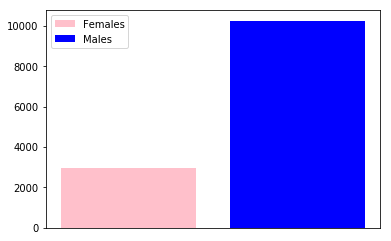

Females: 2966
Males: 10268


In [5]:
female_names_data = pd.read_csv('./faces_data/original_data/female_names.txt', header=None, sep='\n')
male_names_data = pd.read_csv('./faces_data/original_data/male_names.txt', header=None, sep='\n')

female_count = len(female_names_data)
male_count = len(male_names_data)

# plot diagram
fig, ax = plt.subplots()
colors = ['pink', 'blue']
rectangles = ax.bar((1, 2), (female_count, male_count), color=colors, width=0.8)
ax.xaxis.set_visible(False)
ax.legend((rectangles[0], rectangles[1]), ('Females', 'Males'))
plt.show()

print("Females: {}".format(female_count))
print("Males: {}".format(male_count))

From the graph we can see that we have high unbalanced data. Furthermore we have we have a relatively large number of exmples and a huge number number of features `250*250=62500` and each feature has 3 component because the picture is colorful. With the components the features are `187500`! For this reason, I will make some suggestions and simplifications so that I can train my machine learning model on my processor for some tolerable period of time:
- I can get rid of the unbalanced data and the large number of examples by making the women/men ratio ~50/50
- I can reduce the huge number of features by making grayscale image and apply some image transformations. 
- In addition later I can use a feature selection algorithm to reduce the number of features.
- I can perform data normalization because some algorihms works better with normalized data

So there is something to be done. Let's get to work!

TODO:
In owr case we have a small set of traning examples $N \sim 1000$ and relatively large large set of features $M \sim 3000$ i.e. $N < M$. In this case it is assumed that а logistic regression or SVM without a kernel(linear SVM) will perform well.

### Reducing the examples and balancing the data
We have more men than women, so we can take all women and we can randomly get the same number of men:

In [9]:
female_names = female_names_data.get_values()[0:, 0]
male_names = male_names_data.get_values()[0:, 0]

female_names = random.sample(set(female_names), NUMBER_OF_SAMPLES)
male_names = random.sample(set(male_names), NUMBER_OF_SAMPLES)

print("Females: {}".format(len(female_names)))
print("Males: {}".format(len(male_names)))

Females: 2900
Males: 2900


### Separating the data
Let's create two folders where we will hold the representatives of the relevant classes:

In [8]:
source_image_dir = "./faces_data/original_data/lfw_funneled/"
directory_female = "./faces_data/new_data/female/"
directory_male = "./faces_data/new_data/male/"
if not os.path.exists(directory_female):
    os.makedirs(directory_female)
if not os.path.exists(directory_male):
    os.makedirs(directory_male)

In [9]:
def separate_data(face_names_data, source, destination):
    for image_name in face_names_data:
        name = re.match("([A-Za-z_-]+)_(\d+.jpg)", image_name)
        if name is None:
            print("Name: {}".format(image_name))
        name = name.group(1)    
        path = source_image_dir + name + "/" + image_name
#         if os.path.exists:
#             print(path)
        #print(path)
        copyfile(path, destination + image_name)

In [10]:
# separates the data
separate_data(female_names, source_image_dir, directory_female)
separate_data(male_names, source_image_dir, directory_male)

In [14]:
# test print for the selected names
female_image_names = os.listdir("./faces_data/new_data/female")
male_image_names = os.listdir("./faces_data/new_data/male")
print(len(female_image_names))
print(len(male_image_names))

2900


### Feature extraction

Now I'll extract the features from the image following this actions:
1. Get the original image
2. Convet the image to garyscale
3. Define the region of interests. Use haar faces to detect a face (if exist) on the image. If there is more than one faces, I'll get the square with the larger area.
4. Crop the square from the gray image
5. Apply gaussian kernel over the cripped image to reduce the noise.
6. Resize the image to 40x40px  

| | | |
|: - :|: - :|: - :|
|![original image](./markdown_res/Amelia_Vega_0001.jpg) | ![gray image](./markdown_res/Amelia_Vega_0001_gray.bmp) | ![face](./markdown_res/Amelia_Vega_0001_face.bmp) |
| ![cropped face](./markdown_res/Amelia_Vega_0001_cropped.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_kernel.bmp) | ![resized face](./markdown_res/Amelia_Vega_0001_resized.bmp) |

In [8]:
gender_faces_data = None
gender_faces_data = np.empty(shape=(0,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]+1)) #64*64+1
face_cascade = cv2.CascadeClassifier('./faces_data/face.xml')

def extract_features(image_path, label):
    """ Extracts features from a image
    :param image_path: the path to the image
    :param label: the label of the image
    :return: extracted features from the image with the corresponding label as a row matrix
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    row = None
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is not ():
        face = sorted(faces, key=lambda x: (x[2] * x[3]), reverse=True)[0]
        x, y, width, height = face
        face_gray = gray[y: y + height, x: x + width]
        resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
        row = np.append(resized.ravel(), label)

    return row

def append_data(prefix_path, label, gender_faces_data):
    image_names = os.listdir(prefix_path)
    for image_path in image_names:
        # print(image_path)
        curr_row = extract_features(prefix_path + image_path, label)
        if curr_row is not None:
            gender_faces_data = np.append(gender_faces_data, [curr_row], axis=0)
        
    return gender_faces_data  

In [9]:
# Append the female faces
gender_faces_data = append_data('./faces_data/new_data/female/', FEMALE_CLASS, gender_faces_data)
female_data_shape = gender_faces_data.shape

# Append the male faces
gender_faces_data = append_data('./faces_data/new_data/male/', MALE_CLASS, gender_faces_data)
male_data_shape = gender_faces_data.shape

print(female_data_shape)
print(male_data_shape)

AttributeError: 'numpy.ndarray' object has no attribute 'shap'

In [11]:
# Suffle the data
np.random.shuffle(gender_faces_data)
gender_faces_data

array([[126., 111.,  77., ..., 103.,  72.,   0.],
       [  1.,   0.,   4., ...,  12.,  15.,   0.],
       [ 15.,  70., 119., ...,  71.,  72.,   1.],
       ...,
       [ 53.,  60.,  60., ..., 127., 115.,   0.],
       [138., 135., 132., ..., 161., 159.,   1.],
       [162., 195., 183., ...,  91.,  79.,   1.]])

## Feature selection

### Data normalization
It is better to normalize the data before trying diffrent feature selection algorihms

In [25]:
# get features
features = gender_faces_data[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
print(features.shape)

# get labels
labels = gender_faces_data[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

(5481, 1600)
(5481,)
[0. 0. 1. ... 0. 1. 1.]


In [26]:
# scale the data with the StandardScaler algorithm
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)
features

# calculates the final counts
unique, count = np.unique(labels, return_counts=True)
print("Females count: {}".format(count[0]))
print("Males count: {}".format(count[1]))
# out = np.histogram(labels, bins=labels)
print(dict(zip(unique, count)))

# TRAIN TEST SPLIT
# features_train, features_test, labels_train, labels_test = train_test_split(
#     features, labels, train_size=0.7, test_size=0.3, random_state=42)


Females count: 2738
males count: 2743
{0.0: 2738, 1.0: 2743}


### Chose the best features

In [71]:
# pca = PCA(n_components=80)
# pca.fit(features)
# rediced_features = pca.transform(features)
# rediced_features.shape

# logistic_regression = LogisticRegression() # C=0.001
# logistic_regression.fit(rediced_features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
features.shape

(5481, 1600)

In [83]:
features_counts = [80, 140, 200, 260, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {}".format(f_count))
    pca = PCA(n_components=f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(
        reduced_features, labels, train_size=0.7, test_size=0.3, random_state=42)
    #print(reduced_features.shape)
    
    #labels = labels.reshape((len(labels), 1)) # 
    #print(labels.shape)
    
    logistic_regression = LogisticRegression(C=0.001) # C=0.001
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print(train_score)
    print(test_score)
    
    test_scores.append(test_score)
    train_scores.append(train_score)

    
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, train_size=0.7, test_size=0.3, random_state=42)

logistic_regression = LogisticRegression() # C=0.001
logistic_regression.fit(features_train, labels_train)


features_counts.append(1600)
test_scores.append(logistic_regression.score(features_test, labels_test))
train_scores.append(logistic_regression.score(features_train, labels_train))
    
# pca = PCA(n_components=100)
# pca.fit(features)
# rediced_features = pca.transform(features)
# rediced_features.shape

Reducing features to 80
0.8464546402502607
0.8285714285714286
Reducing features to 140
0.8597497393117831
0.8340425531914893
Reducing features to 200
0.863660062565172
0.8364741641337387
Reducing features to 260
0.8657455683003128
0.8389057750759878
Reducing features to 440
0.8691345151199166
0.8425531914893617
Reducing features to 1000
0.8706986444212722
0.8425531914893617


In [84]:
print(test_scores)
print(train_scores)

[0.8285714285714286, 0.8340425531914893, 0.8364741641337387, 0.8389057750759878, 0.8425531914893617, 0.8425531914893617, 0.7939209726443769]
[0.8464546402502607, 0.8597497393117831, 0.863660062565172, 0.8657455683003128, 0.8691345151199166, 0.8706986444212722, 0.9919186652763295]


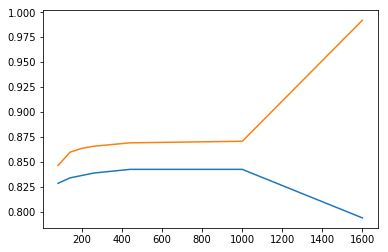

In [85]:
plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)

Now the data for the model is generated. The only thing left is to keep it in a file:

In [24]:
np.savetxt("./genders_data_40x40_pca_200_large.csv", gender_faces_data.astype(np.int), delimiter=",")

## Train logistic regression model
Try Lasso Regression with panalty $L1$ to reduce the number of the features. My intuition suggests that you can reduce the number of dimensions to get a simple model. For example, the features that are at the edges of the images should definitely not have any weight for recognizing the gender. But let's see if intuition lied to me.

In [12]:
gender_faces_data = pd.read_csv('./genders_data_40x40_pca_200_large.csv', sep=',', header=None)

print(gender_faces_data.shape)
gender_faces_data.head()

(5481, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,53.0,60.0,60.0,43.0,55.0,38.0,34.0,50.0,81.0,101.0,...,150.0,156.0,147.0,133.0,119.0,117.0,132.0,127.0,115.0,0.0
1,18.0,9.0,6.0,7.0,6.0,8.0,6.0,30.0,86.0,119.0,...,54.0,62.0,58.0,62.0,78.0,104.0,148.0,162.0,178.0,1.0
2,148.0,195.0,148.0,74.0,67.0,135.0,162.0,166.0,156.0,134.0,...,72.0,101.0,94.0,90.0,72.0,54.0,111.0,85.0,92.0,1.0
3,62.0,53.0,54.0,47.0,42.0,60.0,67.0,50.0,43.0,56.0,...,164.0,176.0,191.0,200.0,202.0,205.0,205.0,209.0,208.0,0.0
4,74.0,74.0,75.0,76.0,73.0,74.0,76.0,68.0,53.0,57.0,...,83.0,87.0,69.0,73.0,73.0,73.0,77.0,76.0,74.0,1.0


In [15]:
features = gender_faces_data.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]] #features = gender_faces_data[:, :50*50] # features = gender_faces_data.as_matrix()[:, :50*50]
print(features.shape)

(5481, 1600)


In [ ]:
labels = gender_faces_data.as_matrix()[:, RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:].ravel() # labels = gender_faces_data.as_matrix()[:, 50*50:].ravel()
print(labels.shape)
print(labels)

## Model selection
### Logistic Regression Model

#### Basic logistic regression

In [166]:
print(features.shape)
print(labels.shape)
pca = SelectPercentile(percentile=100)
pca.fit(features, labels)
rediced_features = pca.transform(features)
rediced_features.shape

features_train, features_test, labels_train, labels_test = train_test_split(
    rediced_features, labels, train_size=0.7, test_size=0.3, random_state=42)

(5481, 1600)
(5481,)


In [161]:
logistic_regression = LogisticRegression(C=0.001)

In [162]:
logistic_regression.fit(features_train, labels_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [163]:
logistic_regression.score(features_test, labels_test)

0.841337386018237

In [164]:
logistic_regression.score(features_train, labels_train)

0.8709593326381647

### Tune the Logistic Regression Params

In [44]:
kfold = StratifiedKFold(n_splits=8) # train with 8
params = {'C': [0.0001, 0.001, 0.01, 1, 10], 'penalty': ['l2', 'l1']}

In [45]:
grid_search_logregr = GridSearchCV(
    logistic_regression, param_grid=params, cv=kfold, return_train_score=True)
grid_search_logregr.fit(features_train, labels_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1'], 'C': [0.0001, 0.001, 0.01, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
grid_search_logregr.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [47]:
grid_search_logregr.best_score_

0.8428050052137643

In [48]:
f1_score(labels_test, grid_search_logregr.predict(features_test))

0.8496732026143791

In [49]:
labels_train[:100]
#labels_train

array([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

In [50]:
labels_train[:100]

array([1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

In [51]:
grid_search_logregr.cv_results_

{'mean_fit_time': array([0.03162497, 0.01650003, 0.03650001, 0.0205    , 0.05875   ,
        0.03299999, 0.08374998, 0.09124997, 0.09175   , 0.080625  ]),
 'mean_score_time': array([0.00050002, 0.        , 0.        , 0.00212502, 0.00012499,
        0.        , 0.00062501, 0.00024998, 0.00024998, 0.00199997]),
 'mean_test_score': array([0.83654849, 0.50130344, 0.84019812, 0.50130344, 0.84280501,
        0.77815433, 0.83811262, 0.83889468, 0.83785193, 0.83785193]),
 'mean_train_score': array([0.86082956, 0.50130344, 0.86552187, 0.50130344, 0.86939525,
        0.78426209, 0.86906007, 0.86924625, 0.86902285, 0.8689856 ]),
 'param_C': masked_array(data=[0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2',
                    'l1'],
    

## Train SVM Model

In [52]:
linear_svm = LinearSVC()
linear_svm.fit(features_train, labels_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [53]:
print("Train score: {}".format(linear_svm.score(features_train, labels_train)))
print("Test score: {}".format(linear_svm.score(features_test, labels_test)))
print("Diff score: {}".format(
    linear_svm.score(features_train, labels_train) - linear_svm.score(features_test, labels_test)))

Train score: 0.862095933264
Test score: 0.844376899696
Diff score: 0.0177190335678


The difference between the train score and test score is relatively high and the train score is very high. That means high variance and/or imbalanced data between the training set and the test set. So we need to perform k-Fold coross validation with stratification and grid search to to evaluate the variance and the best parameters for this algorithm with the concrete amount of training data.

### Tune the Linear SVM Model

In [56]:
kfold_linear_cv = StratifiedKFold(n_splits=8) # train with 8
params_linear_cv = {'C': [0.0001, 0.001, 0.01], 'penalty': ['l2']} # 0.01 is with smaller variance
grid_search_linear_svm = GridSearchCV(
    linear_svm, param_grid=params_linear_cv, cv=kfold_linear_cv, return_train_score=True)

start = time.time()
grid_search_linear_svm.fit(features_train, labels_train)
end = time.time()

In [57]:
print("GridSearchCV took {%.2f} seconds for %d candidate parameter settings."
      % (end - start, len(grid_search_linear_svm.cv_results_['params'])))

GridSearchCV took {1.94} seconds for 3 candidate parameter settings.


In [58]:
grid_search_linear_svm.best_score_

0.8441084462982273

In [59]:
grid_search_linear_svm.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [60]:
# grid_search_linear_svm.grid_scores_
# grid_search_linear_svm

In [61]:
grid_search_linear_svm.cv_results_

{'mean_fit_time': array([0.02700001, 0.03712499, 0.15799999]),
 'mean_score_time': array([0.0025    , 0.00012499, 0.00074998]),
 'mean_test_score': array([0.83967675, 0.84410845, 0.84332638]),
 'mean_train_score': array([0.86548456, 0.86809181, 0.86935797]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l2', 'l2', 'l2'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001, 'penalty': 'l2'},
  {'C': 0.001, 'penalty': 'l2'},
  {'C': 0.01, 'penalty': 'l2'}],
 'rank_test_score': array([3, 1, 2]),
 'split0_test_score': array([0.84407484, 0.85031185, 0.84823285]),
 'split0_train_score': array([0.86348733, 0.87034277, 0.87034277]),
 'split1_test_score': array([0.825     , 0.82916667, 0.825     ]),
 'split1_train_score': array([0.86293206, 0.86769964, 0.87038141]),
 'split2_test_score': arra

### Gaussian SVM Model

In [62]:
svm = SVC(C=0.0001, gamma=2)
svm.fit(features_train, labels_train)
svm.score(features_test, labels_test)

0.49544072948328266

## Random Forest Clasifier

In [63]:
forest = RandomForestClassifier(n_estimators=1500, max_depth=2)
forest.fit(features_train, labels_train)
print("score: {}".format(forest.score(features_test, labels_test)))
print("f1_score: {}".format(f1_score(labels_test, forest.predict(features_test))))

score: 0.750151975684
f1_score: 0.749237339841


In [64]:
print("train score: {}".format(forest.score(features_train, labels_train)))

train score: 0.782846715328


## Adaptive Boost

In [65]:
basic_forest = DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(basic_forest, n_estimators=100)
ada_boost.fit(features_train, labels_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [66]:
ada_boost.score(features_test, labels_test)

0.7939209726443769

In [67]:
ada_boost.score(features_train, labels_train)

0.8493222106360793

## Demo

In [71]:
import cv2
import numpy as np
import time

# data:       https://github.com/opencv/opencv/tree/master/data/haarcascades
# faces, see: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('./faces_data/face.xml')
my_image = None

size = 50

cap = cv2.VideoCapture(0)
is_running = True
while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # looks for faces within the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    w = 10 #30
    h = 10 #50
    for (x, y, width, height) in faces:
        #print("x: {}, y: {}, width: {}, height: {}".format(x, y, width, height))
        # draws a rectangle around the detected face
        cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
        face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]

        im_height = face_gray.shape[0]
        im_width = face_gray.shape[1]
        if cv2.waitKey(1) == ord('q'):
            #cv2.imwrite("aaa.jpg", face_gray)
            resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
            my_image = resized
            #cv2.imwrite("bbbq.jpg", resized)
            time.sleep(2)
            #print((np.ravel(face_gray)))
            is_running = False
            break

    cv2.imshow('frame', frame)
    #print(frame.shape)

    if not is_running:
        break

cap.release()
cv2.destroyAllWindows()


In [72]:
# my_image = cv2.imread('./faces_data/fem_n2.JPG', cv2.IMREAD_GRAYSCALE)
# my_image = cv2.resize(my_image, dsize=RESIZE_SHAPE)
# my_image.shape

# my_image = cv2.imread('./faces_data/gray_3.jpeg', cv2.IMREAD_GRAYSCALE)
# img.shape
# img

In [73]:
#cv2.imwrite('./fem_n3.jpg', my_image)
img = my_image.ravel()
print(img[:100])
print(img.shape)



[ 78  86  93  98 100  52  36  37  41  43  47  46  41  39  39  42  40  50
  47  45  37  36  38  33  34  32  36  39  38  41  58  72 146 168 168 170
 170 170 171 171  71  80  92  93  83  40  40  43  51  51  61  54  63  61
  52  54  57  61  61  57  60  49  45  52  48  43  43  41  44  44  54  61
  83 163 169 169 167 169 169 169  69  78  90  84  41  45  44  54  52  59
  64  75  83  88  93  96 107 104  94 103]
(1600,)


In [74]:
# #cv2.imwrite('./test_img.jpg', my_image)
# row = extract_features('./faces_data/fem_5.jpeg', FEMALE_CLASS)
# img = row[:RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
# img

In [75]:
# img = cv2.imread('./faces_data/male_d1.jpg', 0)
# img = row[:RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
# img = np.ravel(img)
# img

In [76]:
img = pca.transform([img])
img.shape

(1, 200)

In [77]:
img = scaler.transform(img)

In [78]:

result_1 = grid_search_logregr.best_estimator_.predict_proba(img)
result_1

array([[0.06066343, 0.93933657]])

In [79]:
result_2 = ada_boost.predict_proba(img)
result_2

array([[0.49971947, 0.50028053]])

In [80]:
result_3 = forest.predict_proba(img)
result_3

array([[0.46679494, 0.53320506]])

In [81]:
result_3 = linear_svm.predict(img)
result_3

array([1.])

In [82]:
result_4 = grid_search_linear_svm.predict(img)
result_4

array([1.])

In [83]:
#X_transformed

In [84]:
logistic_regression.predict_proba(img)

array([[0.010397, 0.989603]])